In [1]:
import pandas as pd
import polars as pl
df = pd.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet")
df_pl = pl.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet")

# Three Cases
# 1. Fully Empty columns : we can just drop them
# 2. Partially Empty Columns: we can impute them
# 3. Full Columns : No imputation necessary

empty_columns = []
fully_filled_columns = []
partially_empty_columns = []

for feature in df_pl.columns:
    # Count empty and non-empty rows
    empty_rows = df_pl[feature].is_null().sum()
    nonempty_rows = len(df_pl[feature]) - empty_rows

    # Classify the columns based on the counts
    if nonempty_rows == 0:
        empty_columns.append(feature)
    elif empty_rows == 0:
        fully_filled_columns.append(feature)
    else:
        partially_empty_columns.append(feature)

# We don't use df_pl again, so delete it to conserve memory
del df_pl

df.sort_values(['time_id','date_id'])

# drop empty columns using imputer
df = df.drop(empty_columns, axis = 1)

# Fill in partially empty columns
for feature in partially_empty_columns:
    df[feature] = df.groupby('symbol_id')[feature].transform(lambda x: x.ffill().bfill())

# Split data temporally - in partition0 there are 170 days and 849 unique time ids per day
df = df.sort_values(['date_id', 'time_id'])
date_counts = df.date_id.value_counts()
date_counts = pd.DataFrame(date_counts.sort_index())
date_counts['cumulative_sum'] = date_counts['count'].cumsum()

# Organize columns into different groups
TIME_FEATURES = ['relative_timestamp']
MARKET_FEATURES = [f'feature_{i:02}' for i in range(0,79) if f'feature_{i:02}' in df.columns]
RESPONDER_FEATURES = [f'responder_{i}' for i in range(0,9) if f'responder_{i}' in df.columns]
# RESPONDER_FEATURES.remove('responder_6')
SYMBOL_FEATURES = ['symbol_id']

# Normalize Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols_to_normalize = MARKET_FEATURES + RESPONDER_FEATURES
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# Determine splitting points
total = len(df)
train_percentage = 0.6
val_percentage = 0.2
test_percentage = 0.2
apprx_train_len = int(total*train_percentage)
apprx_val_len = int(total*val_percentage) 
apprx_test_len = total - apprx_train_len - apprx_val_len

# Determine Splitting points

def split_func(row):
    s = row['cumulative_sum']
    if s <= apprx_train_len:
        return 'Train'
    elif (s > apprx_train_len) and (s <= apprx_train_len + apprx_val_len):
        return 'Val'
    elif (s > apprx_train_len + apprx_val_len):
        return 'Test'
    else:
        raise ValueError

date_counts['Split'] = date_counts.apply(split_func, axis = 1)
# print(date_counts.Split.value_counts())

last_train_data = date_counts[date_counts.Split == 'Train'].tail(1) 
first_test_data = date_counts[date_counts.Split == 'Test'].head(1)

# Once Splitting points are determined, then make the necessary splits
 
def split_func_df(row):
    s = row['date_id']
    if s <= last_train_data.index[0]:
        return 'Train'
    elif (s > last_train_data.index[0]) and (s < first_test_data.index[0]):
        return 'Val'
    elif (s >= first_test_data.index[0]):
        return 'Test'
    else:
        raise ValueError

# Potentially encode time_id as sine/cosine to capture cyclical nature
# train_df['time_sin'] = np.sin(2 * np.pi * train_df['time_id'] / max_time_id)
# train_df['time_cos'] = np.cos(2 * np.pi * train_df['time_id'] / max_time_id)



In [2]:
df = df[df.symbol_id.isin(range(10))]

In [3]:
encoded = pd.get_dummies(df['symbol_id'], prefix='symbol_id')
max_symbol_id = df['symbol_id'].max()
print(f'This parquet has {max_symbol_id} distinct symbol_ids')
encoded.head()

This parquet has 9 distinct symbol_ids


,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_7,symbol_id_8,symbol_id_9
0,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False
2,False,False,False,False,False,False,True
8,False,True,False,False,False,False,False
9,False,False,False,False,True,False,False


In [4]:
df = pd.concat([df, encoded], axis = 1)
df = df.drop(['symbol_id'], axis = 1)
df.head()

,date_id,time_id,weight,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,...,responder_6,responder_7,responder_8,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_7,symbol_id_8,symbol_id_9
0,0,0,3.889038,0.944836,0.266733,0.292798,-1.038046,-0.73728,0.912814,-0.528156,...,0.889632,0.389633,0.108072,False,True,False,False,False,False,False
1,0,0,1.370613,0.761208,0.169433,0.219469,-0.636408,-0.73728,0.912814,-0.528156,...,0.806566,0.243509,0.889930,False,False,False,False,True,False,False
2,0,0,2.285698,1.161356,0.207122,0.278843,-0.909250,-0.73728,0.912814,-0.528156,...,2.421228,0.752806,0.883280,False,False,False,False,False,False,True
8,0,1,3.889038,1.015072,-0.422322,0.089218,-0.856497,-0.73728,0.912814,-0.528156,...,0.862059,0.390782,0.046669,False,True,False,False,False,False,False
9,0,1,1.370613,0.972411,-0.265482,0.069314,-0.801669,-0.73728,0.912814,-0.528156,...,0.728011,0.011494,0.286561,False,False,False,False,True,False,False


In [5]:
df['Split'] = df.apply(split_func_df, axis = 1)
df['Split'].value_counts()

train_df = df[df.Split == 'Train']
val_df = df[df.Split == 'Val']
test_df = df[df.Split == 'Test']

# LSTM model testing

In [6]:
features = ['date_id', 'time_id', 'feature_06', 'feature_07', 'feature_05', 'feature_68', 'responder_6']+list(encoded.columns)
#features

In [7]:
import numpy as np
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data['responder_6'].iloc[i+sequence_length]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# Create sequences
#features = ['date_id', 'time_id', 'feature_06', 'feature_07', 'feature_05', 'feature_68', 'symbol_id', 'responder_6']
X_train, y_train = create_sequences(train_df[features], sequence_length=50)
X_val, y_val = create_sequences(val_df[features], sequence_length=50)

In [8]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(window_size, num_features)))
# model.add(Dense(1))  # Predicting a single value
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, y_train, epochs=50, batch_size=32)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import TensorBoard

# # Enable mixed precision
# set_global_policy('mixed_float16')

# # Enable XLA optimization
# tf.config.optimizer.set_jit(True)

# Define the model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:


# Create TensorFlow datasets
batch_size = 128  # Adjust for optimal GPU utilization
train_data = tf.data.Dataset.from_tensor_slices((X_train.astype('float'), y_train.astype('float'))).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val.astype('float'), y_val.astype('float'))).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# TensorBoard callback with profiling
tensorboard_cb = TensorBoard(log_dir="./logs", profile_batch='2,10')

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    callbacks=[tensorboard_cb]
)


Epoch 1/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - loss: 0.7502 - mae: 0.5691 - val_loss: 0.9020 - val_mae: 0.6309
Epoch 2/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.7423 - mae: 0.5637 - val_loss: 0.9010 - val_mae: 0.6306
Epoch 3/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.7381 - mae: 0.5633 - val_loss: 0.8932 - val_mae: 0.6283
Epoch 4/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.6394 - mae: 0.5335 - val_loss: 0.6264 - val_mae: 0.5424
Epoch 5/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.5366 - mae: 0.4904 - val_loss: 0.5645 - val_mae: 0.5176
Epoch 6/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.5023 - mae: 0.4752 - val_loss: 0.5487 - val_mae: 0.5101
Epoch 7/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.4755 - mae: 0.4623 - val_loss: 0.5065 - val_mae: 0.4918
Epoch 8/20
3807/3807 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.4397 - mae: 0.4444 - val_loss: 0.4752 - val_mae: 0.4796
Epoch 9/20
3807/3807 ━━━

In [10]:
model.save('model.h5')

In [11]:
X_test, y_test = create_sequences(test_df[features], sequence_length=50)
test_data = tf.data.Dataset.from_tensor_slices((X_test.astype('float'), y_test.astype('float'))).batch(batch_size).prefetch(tf.data.AUTOTUNE)
result = model.evaluate(test_data)

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4266 - mae: 0.4320


In [12]:
sample_df = test_df[test_df.symbol_id_0 == 1].sample(200)
print(len(sample_df))
X_s, y_s = create_sequences(sample_df[features], sequence_length=50)
sample_data = tf.data.Dataset.from_tensor_slices((X_s.astype('float'))).batch(batch_size).prefetch(tf.data.AUTOTUNE)

200


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


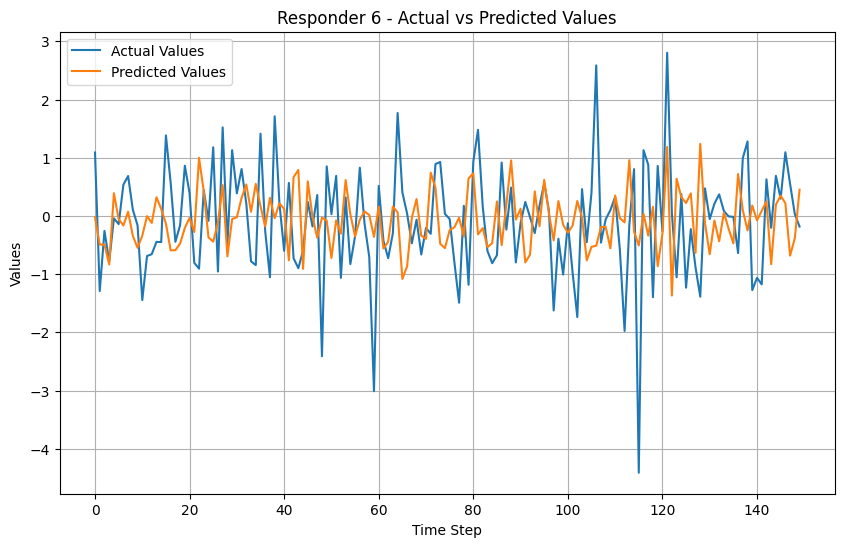

In [13]:
import matplotlib.pyplot as plt

# Get the data for responder_6 in the test set
responder_6_predictions = model.predict(sample_data)
responder_6_actual_values = y_s
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))  # Adjust figure size as needed 
plt.plot(range(len(responder_6_actual_values)), responder_6_actual_values, label='Actual Values')
plt.plot(range(len(responder_6_predictions.squeeze())), responder_6_predictions.squeeze(), label='Predicted Values')  # Squeeze to remove extra dimension
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.title(f'Responder 6 - Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()